In [9]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf

import ta

In [10]:
import MetaTrader5 as mt5
import datetime as dt


Your account number is: 5973438
Your account password is: HREory6!

970154
 
Senha:
MFNcma0!
 
 
Servidor:
ActivTradesCorp-Server

In [11]:
import pytz
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()

'Open', 'High', 'Low', 'Close'

In [12]:
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df

def retorno(df):
    df['Retorno'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

GBP!

In [13]:
def gpb_usd(sinal, hurst_sinal, zscore_sinal, rsi_cat_sinal, stochasticOscillator_sinal, sinal_bb):
    if rsi_cat_sinal <= 0.5:
        if zscore_sinal <= 0.5:
            if sinal <= -0.5:
                if hurst_sinal <= -0.5:
                    return 0
                else:  # if hurst_sinal > -0.5
                    return 0
            else:  # if sinal > -0.5
                if sinal <= 0.5:
                    return 0
                else:  # if sinal > 0.5
                    return 1
        else:  # if zscore_sinal > 0.5
            return 0
    else:  # if rsi_cat_sinal > 0.5
        if stochasticOscillator_sinal <= 0.5:
            return 1
        else:  # if stochasticOscillator_sinal > 0.5
            if hurst_sinal <= -0.5:
                return 1
            else:  # if hurst_sinal > -0.5
                if hurst_sinal <= 0.5:
                    if sinal <= -0.5:
                        return 0
                    else:  # if sinal > -0.5
                        return 1
                else:  # if hurst_sinal > 0.5
                    return 1

In [14]:
def var_gbp(aux):
    df = aux.copy()
    df['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    df['RSL5q'] = pd.qcut(df['RSL5'], q=7, labels=False)
    df['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_cat'] = pd.qcut(df['rsi'], 7,labels=False)

    df['filtro'] = np.where(df["RSL5"] < df["RSL20"], 1, -1) 
    aux['sinal'] = np.where(((df['filtro'] == 1) & ((df['RSL5q'] == 0) | (df['RSL5q'] == 4) | (df['RSL5q'] == 6))), -1,
                            np.where(((df['filtro']== -1) & ((df['RSL5q'] == 0) | (df['RSL5q'] == 1) | (df['RSL5q'] == 3))),1, 0))

    df['rsi_sinal'] = np.where(df['rsi'] <= 0.3, 1, np.where(df['rsi'] <= 0.8, -1, 0))


    aux['rsi_cat_sinal'] = np.where((((df['rsi_sinal'] == 1) | 
                                    ((df['rsi_sinal']== 0) & (df['rsi_cat'] == 0) | (df['rsi_cat'] == 1)))), 1,
                            np.where((((df['rsi_sinal']== -1) & ((df['rsi_cat'] == 0) )|
                                        ((df['rsi_sinal']== 0) & (df['rsi_cat'] == 4) | (df['rsi_cat'] == 5)))),-1, 0)) 
    
    
    aux['rsi_sinal'] = np.where(((aux['sinal'] == -1) & ((df['rsi_cat'] == 4) | (df['rsi_cat'] == 5) | (df['rsi_cat'] == 6))), -1,
                         np.where(((aux['sinal']== 1) & ((df['rsi_cat'] == 0) | (df['rsi_cat'] ==1) | (df['rsi_cat'] == 4))),1, 0))



    df['desvio_padrao'] = df["Retorno"].rolling(window=15).std()
    df['media'] = df["Retorno"].rolling(window=15).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=15).max()
    df['min_diff'] = df['ajuste_media'].rolling(window=15).min()
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)

    aux['hurst_sinal'] = np.where(df['hurst'] > 0.5, 1, np.where(df['hurst'] < 0.45, -1, 0))

    df['std15'] = df['Close'].rolling(15).std()
    df['MA'] = df['Close'].rolling(5).mean()

    df["zscore"] = ((df["Close"]-df['Close'].rolling(5).mean())/df['Close'].rolling(10).std())
    std = (df['zscore'].std())*1.2
    aux['zscore_sinal'] = np.where(df['zscore'] > std, -1, np.where(df['zscore'] < -std, 1, 0))


    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    #df['rsi'] = pd.qcut(df['rsi'], 5,labels=False)





    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=15, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator'] = df['stochasticOscillator']/100
    #df['stochasticOscillator'] = pd.qcut(df['stochasticOscillator'], 5, labels=False)

    aux['stochasticOscillator_sinal'] = np.where(df['stochasticOscillator'] <= 0.2, 1, np.where(df['stochasticOscillator'] < 0.8, -1, 0))



    #bandas de bollingerBand
    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_bollinger_avg'] = bollingerBand.bollinger_mavg()
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    aux['sinal_bb'] = np.where(df['Close']>df['bb_hband'],-1, np.where(df['Close']<df['bb_lband'],1,0))


    aux['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    aux['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    aux['rsi'] = 100 - (100 / (1 + rs))


    aux.dropna(inplace=True)
    return aux


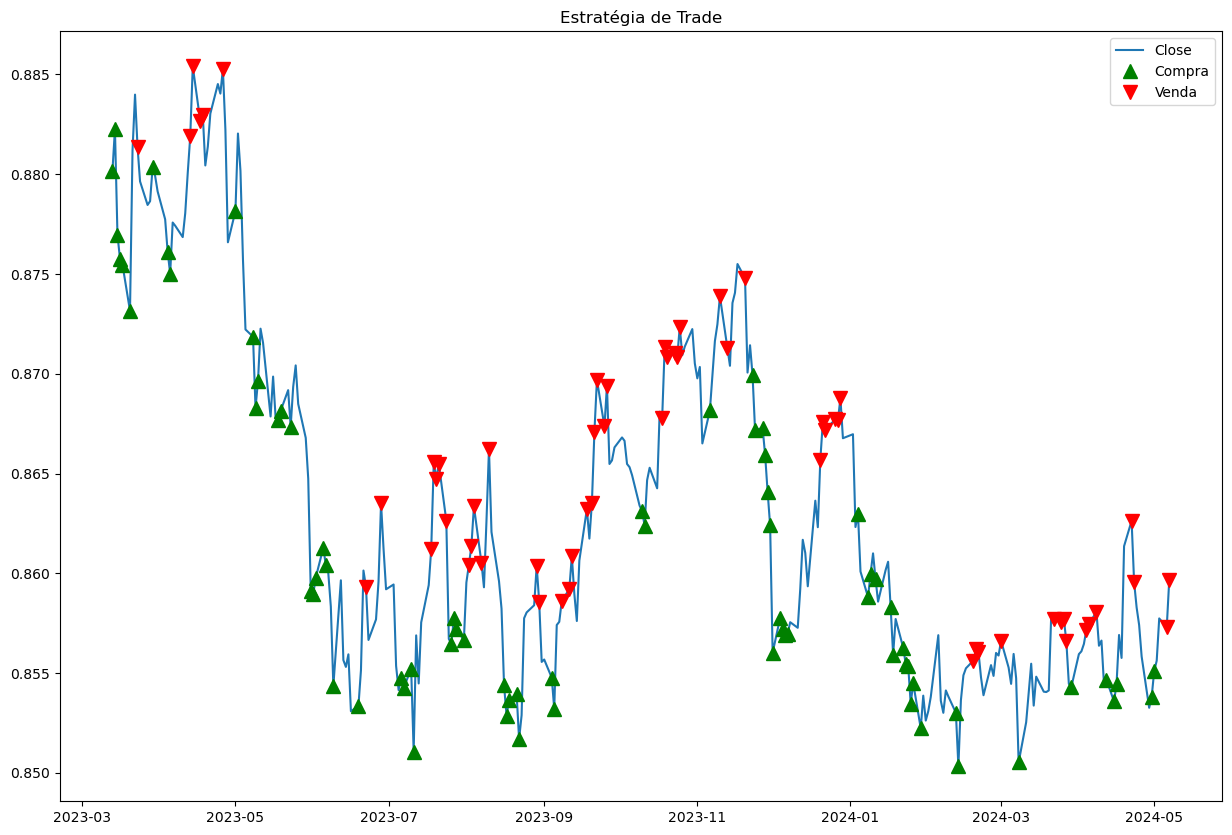

C:\Users\camps pro\AppData\Local\Temp\ipykernel_21976\1644725755.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 1):
C:\Users\camps pro\AppData\Local\Temp\ipykernel_21976\1644725755.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 0):
C:\Users\camps pro\AppData\Local\Temp\ipykernel_21976\1644725755.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

retorno 64.63277308614009
acerto 185
erro 105
acuracia 0.6379310344827587
total de trades 290
total de dias 660
retorno acumulado em % 64.63277308614015
retorno medio do acerto 0.09822609891510652
retorno medio do erro -0.46381108123723774
retorno medio do acerto 0.6193056645685796
stop loss recomendado de: - 0.4305281767786931
Venda


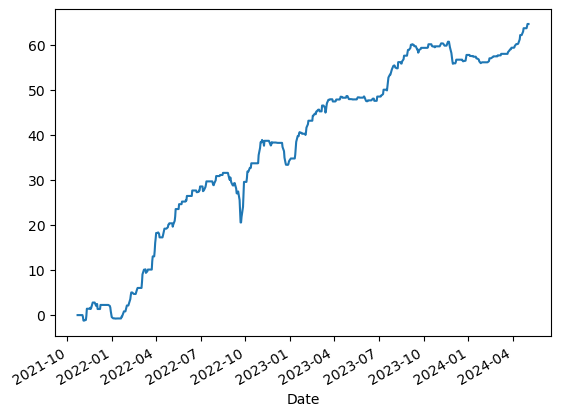

In [15]:
ativos = ["USDJPY", "EURUSD", "GBPUSD", "EURGBP",  "XAUUSD"]
ativo = ativos[3]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 680)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
retorno(g)
var_gbp(g)

g['Previsto'] = g.apply(lambda row: gpb_usd(row['sinal'],row['hurst_sinal'], row['zscore_sinal'], row['rsi_cat_sinal'], row['stochasticOscillator_sinal'], row['sinal_bb']), axis=1)
g['sinal_soma'] = g['hurst_sinal']+g['zscore_sinal']+g['rsi_cat_sinal']+g['stochasticOscillator_sinal']+g['sinal_bb']

g['decisao'] = np.where((g['Previsto'] == 1) &  (g['rsi'] <30) &  (g['RSL20'].shift(1) <0), 1, 
                        np.where(((g['Previsto'] == 0)& (g['rsi']>65)&  (g['RSL20'].shift(1)>0)), -1, 0))



#plotar um grafico das posicoes
plt.figure(figsize=(15,10))
plt.plot(g['Close'].iloc[-300:], label='Close')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == 1].iloc[-300:], '^', markersize=10, color='g', lw=0, label='Compra')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == -1].iloc[-300:], 'v', markersize=10, color='r', lw=0, label='Venda')
plt.title('Estratégia de Trade')
plt.legend()
#sublinhar o que é compra e o que é venda por um periodo de 3 dias apos o sinal

plt.show()
g["Retorno10"] = g["Close"].pct_change(4)*100
g["Alvo10"] = g["Retorno10"].shift(-4)
g['alvo_bin'] = np.where(g['Alvo10'] > 0, 1, 0)   
g['retorno'] = np.where(g['decisao'] == 1, g['Alvo10'], np.where(g['decisao'] == -1, -g['Alvo10'], 0))
#meta['retorno'] = np.where(meta['retorno'] <= -1, -1, meta['retorno'])
g['retorno_acumulado'] = g['retorno'].cumsum()
g['retorno_acumulado'].plot()

acerto = 0
erro = 0
for i in range(len(g)):
    if (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 1):
        acerto +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 0):
        acerto +=1
    elif (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 0):
        erro +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 1):
        erro +=1
print('retorno', g['retorno'].sum())
print('acerto', acerto)
print('erro', erro)
print('acuracia', acerto/(acerto+erro))
print('total de trades', acerto+erro)
print('total de dias' , len(g))
print('retorno acumulado em %', g['retorno_acumulado'][-3])
print('retorno medio do acerto',  g['retorno'].mean())
print('retorno medio do erro',  g['retorno'][g['retorno'] < 0].mean())
print('retorno medio do acerto',  g['retorno'][g['retorno'] > 0].mean())
print('stop loss recomendado de: -', g['Retorno10'].rolling(60).std().tail(1).values[0] * 1.2)
if g['decisao'].iloc[-1] == 1:
    print('Compre')
elif g['decisao'].iloc[-1] == -1:
    print('Venda')
else:
    print('Fique de fora')

In [16]:
g

,Open,High,Low,Close,Retorno,sinal,rsi_cat_sinal,rsi_sinal,hurst_sinal,zscore_sinal,...,RSL20,rsi,Previsto,sinal_soma,decisao,Retorno10,Alvo10,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-22,0.84225,0.84682,0.84211,0.84589,0.004143,0,-1,0,0,0,...,-0.005159,63.380282,0,-2,0,NaN,0.099304,1,0.00000,0.000000
2021-10-25,0.84539,0.84659,0.84276,0.84314,-0.003251,1,0,0,0,0,...,-0.007794,37.286325,1,1,0,NaN,0.142325,1,0.00000,0.000000
2021-10-26,0.84258,0.84358,0.84026,0.84230,-0.000996,0,0,0,0,0,...,-0.007588,43.954660,0,1,0,NaN,0.815624,1,0.00000,0.000000
2021-10-27,0.84133,0.84647,0.84075,0.84431,0.002386,0,-1,0,0,0,...,-0.004081,59.588299,0,-2,0,NaN,0.702349,1,0.00000,0.000000
2021-10-28,0.84374,0.84759,0.84226,0.84673,0.002866,0,-1,0,0,-1,...,-0.000503,68.809731,0,-3,0,0.099304,0.188962,1,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,0.85356,0.85584,0.85285,0.85510,0.001499,1,1,1,0,0,...,-0.001795,26.783115,1,0,1,-0.269416,0.535610,1,0.53561,64.632773
2024-05-02,0.85475,0.85652,0.85449,0.85562,0.000608,0,0,0,1,0,...,-0.001097,36.251920,0,0,0,-0.024538,NaN,0,0.00000,64.632773
2024-05-03,0.85557,0.85865,0.85477,0.85774,0.002478,0,-1,0,0,0,...,0.001360,63.546099,0,-2,0,0.525045,NaN,0,0.00000,64.632773
